# ST VAE experiments
Experiments with spatial data

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F

from vae import VAE_CNN, VAE_LINEAR

## Global variables

In [4]:
DATA_PATH = "segmentation"

In [5]:
CUDA_DEVICE_NUM = 3
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

Device: cuda:3


## Helperfunctions

In [6]:
def visualize_gene_count_reconstruction(vae_model, test_data_iterator):
    fig, axes = plt.subplots(2, 4, figsize=(10, 2))

    test_batch = next(test_data_iterator)
    example_images = test_batch[0].to(DEVICE)
    x_flat, _, _ = vae_model(example_images)
    x_reconstructed = x_flat.view(-1, 1, 5, 23)

    for i in range(4):
        img = example_images[i].cpu().detach().numpy()
        img_reshaped = np.squeeze(img).reshape((5, 23))
        img_recon = x_reconstructed[i].cpu().detach().numpy()

        uint8_image = (img_reshaped * 255).round().astype(np.uint8)
        uint8_image_recon = (np.squeeze(img_recon) * 255).round().astype(np.uint8)

        axes[0, i].imshow(uint8_image, cmap='gray')
        axes[0, i].axis('off')

        axes[1, i].imshow(uint8_image_recon, cmap='gray')
        axes[1, i].axis('off')

    fig.suptitle('Reconstruction examples', fontsize=16, y=0.8)
    plt.tight_layout()

## Data load

## Loss functions

In [7]:
# Simple mean-square error loss function
def mse_loss(x, x_recontsructed, z_mean, z_sigma):
    loss = nn.MSELoss()(x, x_recontsructed)
    return loss

In [8]:
# Implement VAE loss: Combine reconstruction loss with kl-divergance
def vae_loss_function_constructor(kl_weight):
    def vae_loss(x, x_recontsructed, z_mean, z_sigma):
        reconstruction_loss = nn.BCELoss(reduction="sum")(x, x_recontsructed)
            
        kld_loss = torch.mean(-0.5 * torch.sum(1 + z_sigma - z_mean ** 2 - z_sigma.exp(), dim = 1), dim = 0)

        loss = reconstruction_loss + kl_weight * kld_loss
        return loss
    
    return vae_loss

In [9]:
def beta_vae_loss_constructor(kl_weight, beta=1):
    def beta_vae_loss(x, x_recontsructed, z_mean, z_sigma):
        reconstruction_loss = nn.BCELoss(reduction="sum")(x, x_recontsructed)
        kld_loss = torch.mean(-0.5 * torch.sum(1 + z_sigma - z_mean ** 2 - z_sigma.exp(), dim = 1), dim = 0)

        loss = reconstruction_loss + beta * kld_loss * kl_weight
        return loss

    return beta_vae_loss

## ST experiments

## Data processing
Process the transcript spots (x,y) into a feasible input array fro a VAE.

In [10]:
fov = 45
cell_index = 13
fov_folder_path = os.path.join(DATA_PATH, f'fov_{fov}')

fov_cell_meta_df = pd.read_csv(os.path.join(fov_folder_path, "cell_meta_data.csv"))
transcripts_df = pd.read_csv(os.path.join(fov_folder_path, "cell_transcripts.csv"))
test_cell_transcripts_df = transcripts_df[transcripts_df['cell_index']==cell_index]

In [11]:
test_cell_transcripts_df

,Gene,barcode_id,x,y,cell_index
10631,Fezf2,41,1656.6030,154.967500,13
11044,Slc17a7,87,1611.4423,121.230965,13
11047,Slc17a7,87,1597.9474,126.175160,13
16069,Vegfb,112,1643.0876,150.744100,13
18595,Apoe,4,1622.7189,153.909530,13
...,...,...,...,...,...
132072,Selenop,81,1639.9218,132.407460,13
132727,Fth1,44,1653.0691,118.035095,13
132732,Fth1,44,1642.0786,119.828140,13
132808,Fth1,44,1635.8129,165.851350,13


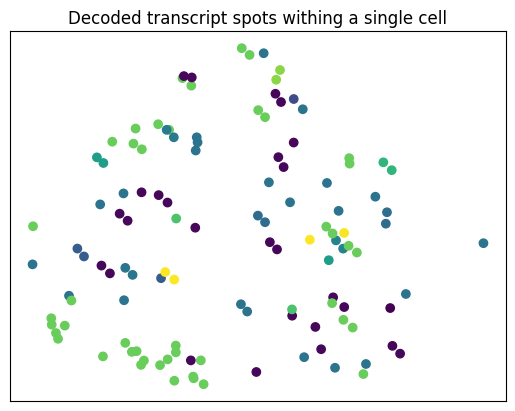

In [16]:
xs = test_cell_transcripts_df['x']
ys = test_cell_transcripts_df['y']
colors = test_cell_transcripts_df['barcode_id']

plt.scatter(xs, ys, marker='o', c=colors)

plt.title("Decoded transcript spots withing a single cell")
plt.xticks([])
plt.yticks([])
plt.show()

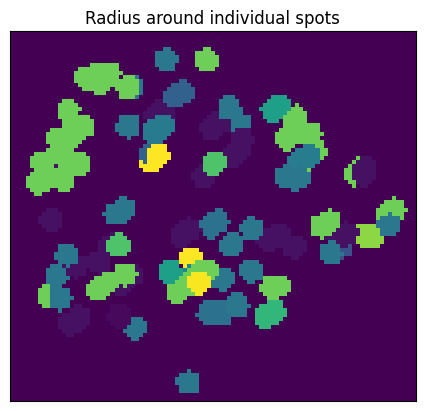

In [19]:
x_min = int(np.min(test_cell_transcripts_df['x'].values))
y_min = int(np.min(test_cell_transcripts_df['y'].values))
width = int(np.max(test_cell_transcripts_df['x'].values) - x_min)+12
height = int(np.max(test_cell_transcripts_df['y'].values) - y_min)+12
arr = np.zeros((width, height), dtype=np.uint8)  # Use dtype=np.uint8 for values in [0, 115]

max_radius = 3
for _, transcripts in test_cell_transcripts_df.iterrows():
    x = transcripts['x'] - x_min + 6 # padding on x axis
    y = transcripts['y'] - y_min + 6 # padding on y axis
    value = transcripts['barcode_id'] + 1 # 0 represents background

    # Iterate through the array and set values inside the circle
    for i in range(width):
        for j in range(height):
            distance = np.sqrt((i - x) ** 2 + (j - y) ** 2)
            if distance <= max_radius:
                arr[i, j] = value

plt.imshow(arr)
plt.xticks([])
plt.yticks([])
plt.title("Radius around individual spots")
plt.show()

#### one-hot encoding

In [ ]:
x = torch.tensor([[0,1,2], [2,3,2]])
test = F.one_hot(x, num_classes=4)
test.shape

## Spatial transcripts VAE experiments

### Dataset

In [ ]:
class TranscriptDataset(Dataset):
    def __init__(self, segmentation_folder, input_dim, n_genes, fov_range=None):
        
        self.cell_meta_df = pd.DataFrame([], columns=['cell_index', 'X', 'Y'])
        self.input_dim = input_dim
        fov_range = fov_range if fov_range else len(list(os.walk(segmentation_folder)))

        gene_counts_ = []
        for fov in tqdm(fov_range):
            fov_seg_folder = f'fov_{fov}'
            fov_folder_path = os.path.join(DATA_PATH, fov_seg_folder)

            if not os.listdir(fov_folder_path):
                continue

            gene_count_dict = np.load(os.path.join(fov_folder_path, "gene_count.npy"), allow_pickle=True).item()
            gene_count_list = list(gene_count_dict.values())

            cell_indecies = list(gene_count_dict.keys())
             
            fov_cell_meta_df = pd.read_csv(os.path.join(fov_folder_path, "cell_meta_data.csv"))
            fov_cell_meta_df['cell_index'] = cell_indecies

            gene_counts_.extend(gene_count_list)
            self.cell_meta_df = pd.concat([fov_cell_meta_df, self.cell_meta_df], ignore_index=True)

        gene_counts = np.array(gene_counts_)
        self.gene_counts = gene_counts/np.max(gene_counts)

    def __getitem__(self, index):
        gene_count_sample = self.gene_counts[index]
        cell_meta = self.cell_meta_df.loc[index]
        cell_index = [cell_meta['cell_index'], cell_meta['X'], cell_meta['Y']]

        return (torch.tensor(gene_count_sample, dtype=torch.float32), torch.tensor(cell_index))

    def __len__(self):
        return len(self.gene_counts)

### VAE

In [ ]:
EPOCHS = 20
BATCH_SIZE = 32

INPUT_DIM = 76
Z_DIM = 32
H_DIM = 64

In [ ]:
transcript_train_dataset = transformed_dataset = TranscriptDataset(
        segmentation_folder=DATA_PATH,
        input_dim=INPUT_DIM,
        fov_range=range(52)
    )
transcript_train_loader = DataLoader(dataset=transcript_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

transcript_test_dataset = transformed_dataset = TranscriptDataset(
        segmentation_folder=DATA_PATH,
        input_dim=INPUT_DIM,
        fov_range=range(53, 121)
    )
transcript_test_loader = DataLoader(dataset=transcript_test_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader = iter(transcript_test_loader)

In [ ]:
vae_cnn = VAE_CNN(input_dim=INPUT_DIM, h_dim=H_DIM, z_dim=Z_DIM)
vae_cnn.to(DEVICE)

# calculate the 'kl_weight'
kl_weight = BATCH_SIZE / len(transcript_train_loader.dataset)
loss_function = vae_loss_function_constructor(kl_weight)

optimizer = torch.optim.Adam(vae_cnn.parameters(), lr=0.001)